# Автоенкодери (Autoencoders)

In [2]:
import math

import numpy as np
import pandas as pd
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Lambda, Concatenate
from keras.optimizers import RMSprop, Adam
from keras import regularizers, objectives, metrics
from keras.models import Model
from keras import backend as K

from IPython.display import display

%matplotlib inline
# sns.set()

Using TensorFlow backend.
/home/rbank/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Автоенкодери
* Тренирането на дълбоки невронни мрежи е трудно.
* Проблеми свързани с exploding and vanishing gradients.
* Автоенкодерите помагат за по-стабилното трениране на дълбоки модели.
* Автоенкодерите са unsupervised техника за трениране.
* Използват се за претрениране на слоевете.
* След претрениране моделът може да бъде трениран с labels и supervised learning.

# Автоенкодери

* Автоенкодерите са алгоритъм за компресия и декомпресия на данни.
* Създават специфичен за данните модел.
* Компресия със загуба на информация.
* Самоубачава се.
* Почти винаги се имплементира с невронни мрежи.

# Фомрулировка на Автоенкодерите:

* Layer 1 - `encoder` :

$$z = g(W_1x + b_1) $$

* Layer 2 - `decoder`:

$$\tilde{x} = g(W_2z + b_2) $$

![](imgs/autoencoder.png)

# Добре ли се справят с компресия?

* Обикновенно - не. 
* Стандартни алгоритми за компресия (JPEG или mp3) се справят доста по-добре с компресия на информацията.
* Имат нужда от много информация и ако са тренирани на снимки с лица, няма да се справят с компресия на снимки с дървета.
* Възможно е за конкретен специфичен пример да се справят по-добре от стандартен алгоритъм.


# За какво се използват?

* В периода 2012 - 2015 се използват за претрениране на слоевете на NN с цел подобряване на дълбоките модели.
* Заменят се от техники, като Xavier Initialization, Batch Normalization (2014) и Residual Learning (2015).

# В момента се ползват за:

* Data Denoising.
* Feature Space Reduction.

# Да построим Aвтоенкодер

Ще се опитаме да кодираме снимките от MNIST.

In [2]:
encoding_dim = 32

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [3]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


# Да си създадем и лесен начин да кодираме и декодираме снимките.

In [4]:
encoder = Model(input_img, encoded)


encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]

decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [6]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.3762 - val_loss: 0.2726
Epoch 2/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.2654 - val_loss: 0.2550
Epoch 3/50
60000/60000 [==============================] - 5s 90us/step - loss: 0.2447 - val_loss: 0.2321
Epoch 4/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.2239 - val_loss: 0.2138
Epoch 5/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.2087 - val_loss: 0.2011
Epoch 6/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1977 - val_loss: 0.1916
Epoch 7/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.1895 - val_loss: 0.1843
Epoch 8/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1828 - val_loss: 0.1783
Epoch 9/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.1770 - val_loss: 0.1729
Epoch

* След 50 епохи, автоенкодерът достига стабилен loss за train/test със стойност около 0.10. 

* Можем да визуализираме оригиналните снимки и тези след кодиране и декодиране.

In [7]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [8]:
print(encoded_imgs[0])
print("MEAN for all:", encoded_imgs.mean())

[ 13.59445572   5.50733614   3.54311371   3.60174322   9.14233208
   9.53241062   1.28111327   5.71863842   6.09462595  10.34986877
   3.37406969   4.18556452   5.74381876   2.4317019    6.90193558
   1.55012012  12.67092037   1.64501488   7.76964092   8.37365818   0.
   7.87777042   3.00692415   9.07615662   6.40732861   4.55597115
   3.94036579   3.54775143  11.80863762   8.86352444   8.33599091
   5.57673645]
MEAN for all: 7.70559


In [9]:
def plot_imgs():
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


# Да видим как са се е справил декодера с възстановяването от 32 неврона.

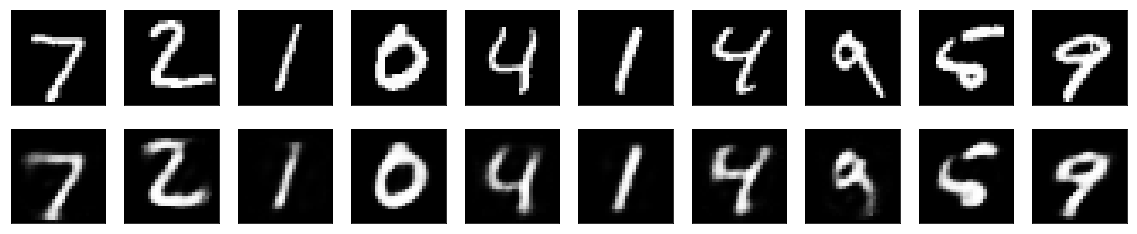

In [10]:
plot_imgs()

# Успяхме да кодираме 784px снимка в 32 неврона.

* Какво научи моделът? 

Да направим експеримент:

* Ще създадем изкуствени кодирани данни.
* Ще имаме само 1 активиран неврон от репрезентационния слой (кодираните 32 стойности).
* Ще декодираме тези вектори.

In [3]:
x = np.identity(32) * 7
x

array([[ 7.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  7.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  7., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  7.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  7.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  7.]])

In [12]:
x_ = decoder.predict(x)
x_

array([[ 0.27642229,  0.2206874 ,  0.26283497, ...,  0.26905191,
         0.23778631,  0.2108586 ],
       [ 0.40509966,  0.47117853,  0.42399797, ...,  0.5620904 ,
         0.40360263,  0.51611042],
       [ 0.41522869,  0.286192  ,  0.42866999, ...,  0.44645798,
         0.26473755,  0.37717563],
       ..., 
       [ 0.56603575,  0.33768296,  0.34514579, ...,  0.60104406,
         0.46325803,  0.48020318],
       [ 0.34240335,  0.34297884,  0.36209527, ...,  0.48396745,
         0.36181593,  0.46001524],
       [ 0.38511407,  0.48694256,  0.433184  , ...,  0.37177661,
         0.53450149,  0.4883486 ]], dtype=float32)

In [13]:
def plot_imgs_x_():
    plt.figure(figsize=(16, 8))
    for i in range(len(x_)):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(x_[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


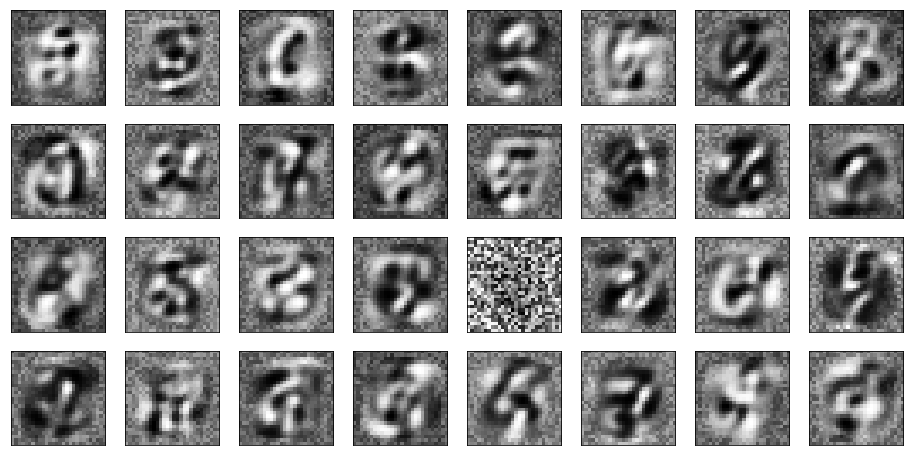

In [14]:
plot_imgs_x_()

# Обратният експеримент:
* Визуализация на снимката, която максимално активира само един от невроните в скрития слой.
* По-сложен за имплементиране, за това ще покажем резултатите от друг модел.

![](imgs/ExampleSparseAutoencoderWeights.png)

In [15]:
# x_identity = Input(shape=(1,))
# W_image = Dense(784, activation='relu')(x_identity)

# encoder_layer = encoder.layers[-1]
# encoded_ = encoder_layer(W_image)
# encoded_.trainable = False

# find_image = Model(x_identity, encoded_)

# find_image.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy')

# x_id_train = np.array([[1]])
# y_enc_train = np.zeros((1,32))
# # y_enc_train[0,10] = 10
# # y_enc_train[0,13] = 10
# # y_enc_train[0,12] = 10
# y_enc_train[0,11] = 10

# find_image.fit(x_id_train, y_enc_train,
#                epochs=5000,
#                batch_size=1,
#                shuffle=False,
#                verbose=0)

# plt.imshow(find_image.layers[1].get_weights()[0].reshape(28,28))

# Sparse Autoencoder

* В предишния пример репрезентацията беше ограничена само от броя на невроните в скрития слой (32).
* В такъв случай обикновенно автоенкодера намира приближение на PCA. 
* За допълнително ограничение можем да добавим L1 регуларазиция. 

# Deep Аutoencoder

* Не е нужно да се ограничаваме само с 1 слой.
* Ще покажем и как да ползваме `tensorboard` с `Keras`.

In [16]:
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [17]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total para

In [18]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 80us/step - loss: 0.3442 - val_loss: 0.2640
Epoch 2/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.2581 - val_loss: 0.2493
Epoch 3/100
60000/60000 [==============================] - 5s 79us/step - loss: 0.2421 - val_loss: 0.2331
Epoch 4/100
60000/60000 [==============================] - 5s 81us/step - loss: 0.2203 - val_loss: 0.2102
Epoch 5/100
60000/60000 [==============================] - 5s 81us/step - loss: 0.2051 - val_loss: 0.1996
Epoch 6/100
60000/60000 [==============================] - 5s 82us/step - loss: 0.1959 - val_loss: 0.1902
Epoch 7/100
60000/60000 [==============================] - 5s 81us/step - loss: 0.1879 - val_loss: 0.1833
Epoch 8/100
60000/60000 [==============================] - 5s 80us/step - loss: 0.1796 - val_loss: 0.1745
Epoch 9/100
60000/60000 [==============================] - 5s 81us/step - loss: 0.1725 - val_loss: 0.1

# Дълбокият автоенкодер постига по-добри train/test loss стойности.

* Визуално снимките изглеждат сходно с първия модел.
* За да стартираме тензорборд изпълняваме: `tensorboard --logdir=/tmp/autoencoder` в конзолата.

# Convolutional Autoenders

* Следващият път ще обясним Convolutional Neural Networks.
* Но и за тях има автоенкодер.
* Сега само ще покажем как би излглеждал автоенкодера ако е конволюционнен.

In [19]:
input_img = Input(shape=(28, 28, 1))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [20]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

# C-AE постига по-добри резултати за loss, функцията, но ползва 128 неврона: 4\*4\*8

# Denoising Autoencoders

* Ще използваме конвулюционния автоенкодер за да изчистим снимките от шум. 
* За целта първо ще вкараме Гаусов шум в снимките и ще трениране с тях.
* За output ще използваме оригиналните снимки (без шум).

In [21]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Да видим какви снимки генерирахме:

In [22]:
def plot_noisy_imgs():
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


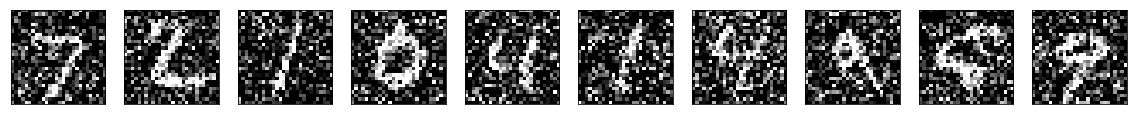

In [23]:
plot_noisy_imgs()

# Някой от снимките са напълно неразпознаваеми.

In [24]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [25]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [26]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/denoising', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 158s 3ms/step - loss: 0.1972 - val_loss: 0.1307
Epoch 2/100
60000/60000 [==============================] - 159s 3ms/step - loss: 0.1233 - val_loss: 0.1155
Epoch 3/100
60000/60000 [==============================] - 158s 3ms/step - loss: 0.1148 - val_loss: 0.1128
Epoch 4/100
60000/60000 [==============================] - 151s 3ms/step - loss: 0.1103 - val_loss: 0.1070
Epoch 5/100
60000/60000 [==============================] - 136s 2ms/step - loss: 0.1078 - val_loss: 0.1067
Epoch 6/100
60000/60000 [==============================] - 143s 2ms/step - loss: 0.1059 - val_loss: 0.1051
Epoch 7/100
60000/60000 [==============================] - 138s 2ms/step - loss: 0.1046 - val_loss: 0.1039
Epoch 8/100
60000/60000 [==============================] - 135s 2ms/step - loss: 0.1035 - val_loss: 0.1028
Epoch 9/100
60000/60000 [==============================] - 132s 2ms/step - loss: 0.1027 - val_

# Да погледнем тест сета преди и след преминаване през Автоенкодера.

In [44]:
# autoencoder.save('da.h5')
# autoencoder = keras.models.load_model('da.h5')

In [27]:
da = autoencoder

def plot_denoised_imgs():
    
    n = 10 
    plt.figure(figsize=(20, 6))
    x_ = da.predict(x_test_noisy[:n])
    
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(x_[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display original
        ax = plt.subplot(3, n, i + 1 + n*2)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

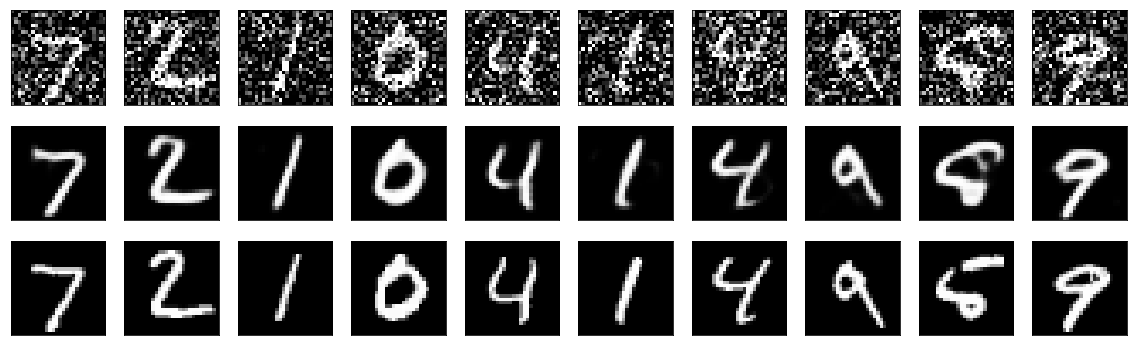

In [28]:
plot_denoised_imgs()


# Изглежда, че работи доста добре.

* Ако се скалира към по-голяма конвулюционна мрежа, може да се ползва за изчистване на шум от документи или аудио сигнали.
* Има интересен dataset в kaggle: https://www.kaggle.com/c/denoising-dirty-documents


# Sequence-to-sequence Autoencoder

* Автоенкодерите могат да се използват и с поредици и рекурентни NN.
* За целта се използва RNN за да превърне входната поредица в един вектор съдържащ информацията за цялата поредица. 
* След това повтаря същият вектор `n` пъти, където `n` е броя на стъпки в изхода.
* Използва се отново рекурента мрежа за да се превърне константната поредица към желаната.


* Ще стане по-ясно, след като обясним рекурентните мрежи. За сега само споменаваме, че съществува.

# Variational Аutoencoder (VAE)

* По-сложнен вариант на автоенкодерите.
* Автоенкодер, който учи латентни (скрити) променливи за входа на данните.
* Вместо да учи репрезентационна функция, се учи на параметрите на вероятностната дистрибуция на входните данни.
* Ако семплираме точки от тази дистрибуция можем да генерираме нови данни.
* Генеративен модел.

# Как работи VAE?

* Първо енкодера превръща входните данни `x` в параметри от латентно пространство.
* Отбелвзваме ги с `z_mean` и `z_log_simga`. 
* След това, теглим случайно семпли, чрез `z = z_mean + exp(z_log_sigma) * epsilon`.
* `epsilon` е случаен нормален тензор.
* Накрая декодер проектира латентните точки към оригиналните входни данни.

* Параметрите на модела се тренират чрез две loss функции:
* Loss за реконструкцията изтеглените семпли към оригиналните данни - също, като при предишните автоенкодери.
* `KL divergence` между научената латента дистрибуция и тази на оригиналните данни, работеща като регуларизация.
* VAE може да работи и без `KL divergence`, въпреки, че помага доста в тренирането и регуларизацията.

* Информация за `KL divergence`: [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)


```
The Kullback–Leibler divergence (also called relative entropy) is a measure of how one probability distribution diverges from a second, expected probability distribution.
...
In the simple case, a Kullback–Leibler divergence of 0 indicates that we can expect similar, if not the same, behavior of two different distributions, while a Kullback–Leibler divergence of 1 indicates that the two distributions behave in such a different manner that the expectation given the first distribution approaches zero

```

$$ {\displaystyle D_{\mathrm {KL} }(P\|Q)=-\sum _{i}P(i)\,\log {\frac {Q(i)}{P(i)}},} $$

# Ще направим имплементацията на VAE

* Ще започнем с предефиниране на няколко параметъра

In [29]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

# Ще продължим с дефиниране на енкодера.

* Мапва входа към параметрите на латентната дистрибуция.


In [30]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_var = Dense(latent_dim, name='z_log_var')(h)

# Можем да използваме параметрите `z_mean` и `z_log_sigma` за да теглим нови подобни точки от латентното пространство.

In [31]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Накрая можем да мапнем семплираните точки отново към реконструираните входове.

In [32]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Ще дефинираме лос функцията

In [33]:
from keras.layers import Layer

In [34]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

# Ще създадем модела

In [35]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 256)          200960      input_6[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_9[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_9[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

/Users/lachezar/.pyenv/versions/3.6.2/envs/fmi/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  This is separate from the ipykernel package so we can avoid doing imports until


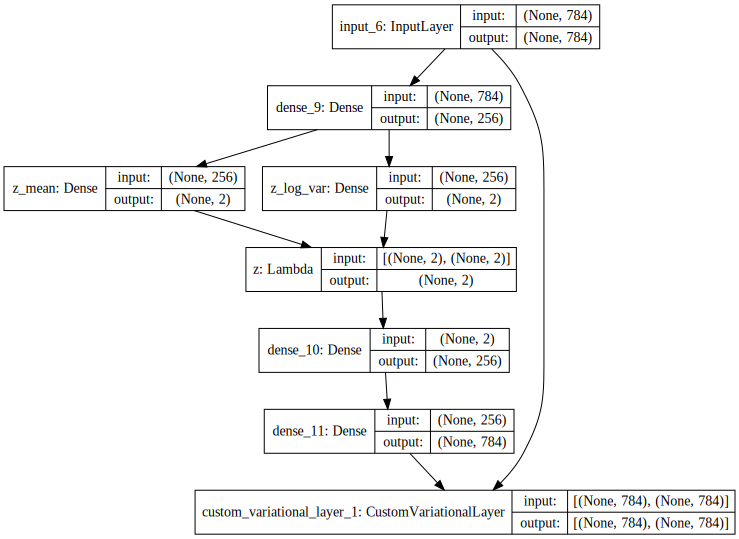

In [36]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg',))

In [37]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [38]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 117us/step - loss: 190.5654 - val_loss: 171.8497
Epoch 2/50
60000/60000 [==============================] - 7s 109us/step - loss: 170.3877 - val_loss: 168.4354
Epoch 3/50
60000/60000 [==============================] - 6s 104us/step - loss: 166.8283 - val_loss: 165.7834
Epoch 4/50
60000/60000 [==============================] - 6s 105us/step - loss: 164.3685 - val_loss: 163.9761
Epoch 5/50
60000/60000 [==============================] - 7s 110us/step - loss: 162.6021 - val_loss: 162.3613
Epoch 6/50
60000/60000 [==============================] - 6s 105us/step - loss: 161.1782 - val_loss: 160.9790
Epoch 7/50
60000/60000 [==============================] - 6s 104us/step - loss: 159.9598 - val_loss: 159.9056
Epoch 8/50
60000/60000 [==============================] - 6s 106us/step - loss: 158.9026 - val_loss: 158.8321
Epoch 9/50
60000/60000 [==============================] - 6s 105us/ste

# Понеже избрахме латентно пространство с две измерения можем да направим визуализации.

In [39]:
def plot_encoded_vae():
    sns.reset_orig()
    encoder = Model(x, z_mean)

    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()


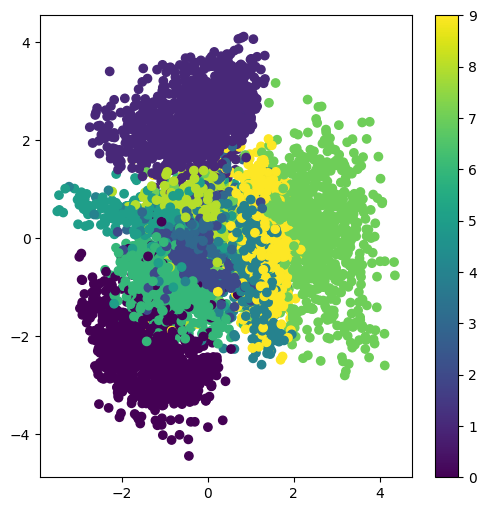

In [40]:
plot_encoded_vae()

In [41]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [42]:
def plot_generated_vae():
    from scipy.stats import norm
    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()


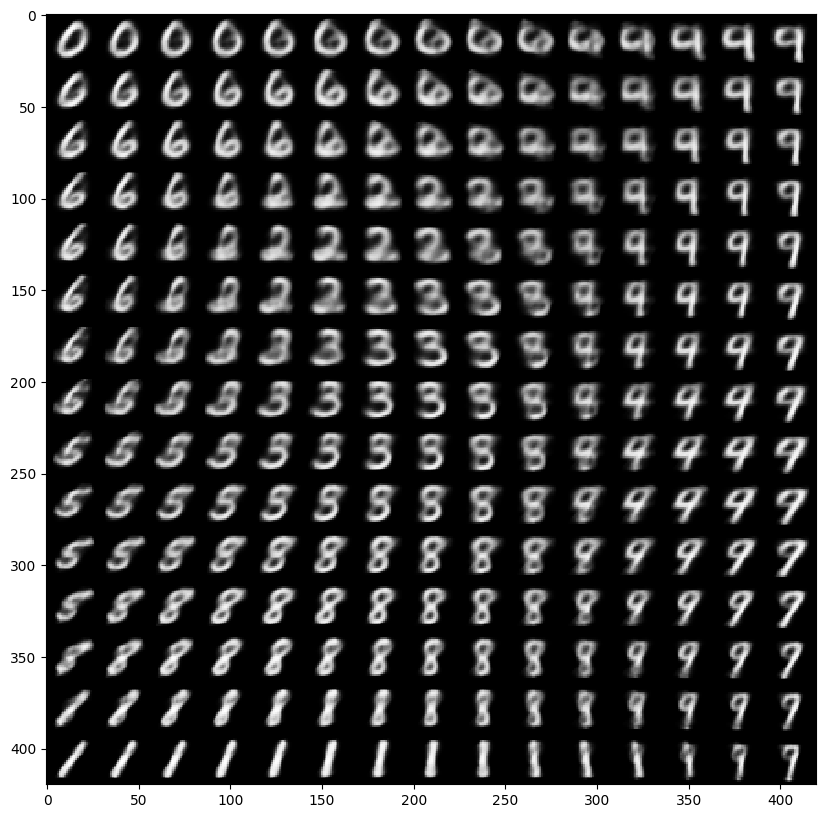

In [43]:
plot_generated_vae()

In [45]:
# vae.save('vae.h5')
# encoder.save('vae_encoder.h5')
# generator.save('vae_generator.h5')

# References:
Autoencoders:

* http://proceedings.mlr.press/v27/baldi12a/baldi12a.pdf
* http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/
* https://cs.stanford.edu/~quocle/tutorial2.pdf
* https://lazyprogrammer.me/a-tutorial-on-autoencoders/
* https://wiseodd.github.io/techblog/2016/12/03/autoencoders/
* https://hsaghir.github.io/data_science/denoising-vs-variational-autoencoder/
